# EDA

In [1]:
import os
import typing

import joblib
import pandas as pd
import numpy as np
import scipy
import sklearn.metrics
import seaborn as sns
import matplotlib.pyplot as plt
from pyts.image import RecurrencePlot, MarkovTransitionField, GramianAngularField

In [2]:
import crunch

crunch = crunch.load_notebook()

loaded inline runner with module: <module '__main__'>

cli version: 6.6.1
available ram: 15.73 gb
available cpu: 16 core
----


In [3]:
# Load the data simply
X_train, y_train, X_test = crunch.load_data()

data\X_train.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/X_train.parquet (204327238 bytes)
data\X_train.parquet: already exists, file length match
data\X_test.reduced.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/X_test.reduced.parquet (2380918 bytes)
data\X_test.reduced.parquet: already exists, file length match
data\y_train.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/y_train.parquet (61003 bytes)
data\y_train.parquet: already exists, file length match
data\y_test.reduced.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/y_test.reduced.parquet (2655 bytes)
data\y_test.reduced.parquet: already exists, file length match


### Understanding `X_train`

The training data is structured as a pandas DataFrame with a MultiIndex:

**Index Levels:**
- `id`: Identifies the unique time series
- `time`: The timestep within each time series

**Columns:**
- `value`: The actual time series value at each timestep
- `period`: A binary indicator where `0` represents the **period before** the boundary point, and `1` represents the **period after** the boundary point

In [4]:
X_train

value  period
id    time                  
0     0    -0.005564       0
      1     0.003705       0
      2     0.013164       0
      3     0.007151       0
      4    -0.009979       0
...              ...     ...
10000 2134  0.001137       1
      2135  0.003526       1
      2136  0.000687       1
      2137  0.001640       1
      2138  0.001074       1

[23715734 rows x 2 columns]

时间序列长度描述性统计
 count    10001.000000
mean      2371.336266
std        482.645935
min       1258.000000
25%       1991.000000
50%       2369.000000
75%       2743.000000
max       3478.000000
dtype: float64
时间序列长度分布


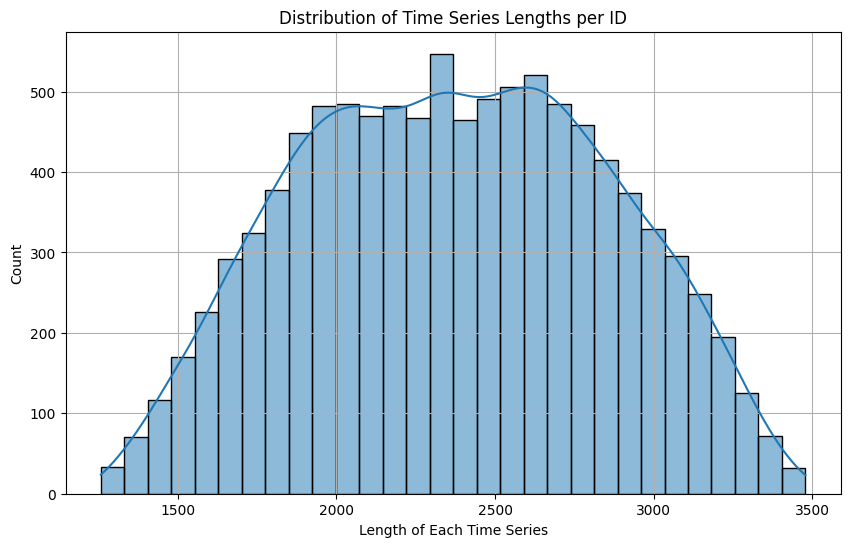

In [10]:
lengths = X_train.groupby('id').size()
print('时间序列长度描述性统计\n', lengths.describe())
print('时间序列长度分布')
plt.figure(figsize=(10, 6))
sns.histplot(lengths, bins=30, kde=True)
plt.xlabel('Length of Each Time Series')
plt.ylabel('Count')
plt.title('Distribution of Time Series Lengths per ID')
plt.grid(True)
plt.show()

Period 0 长度分布描述性统计:
 count    10001.000000
mean      1746.735826
std        432.507524
min       1000.000000
25%       1368.000000
50%       1749.000000
75%       2119.000000
max       2499.000000
Name: 0, dtype: float64
Period 1 长度分布描述性统计:
 count    10001.00000
mean       624.60044
std        215.98523
min        250.00000
25%        435.00000
50%        629.00000
75%        810.00000
max        999.00000
Name: 1, dtype: float64


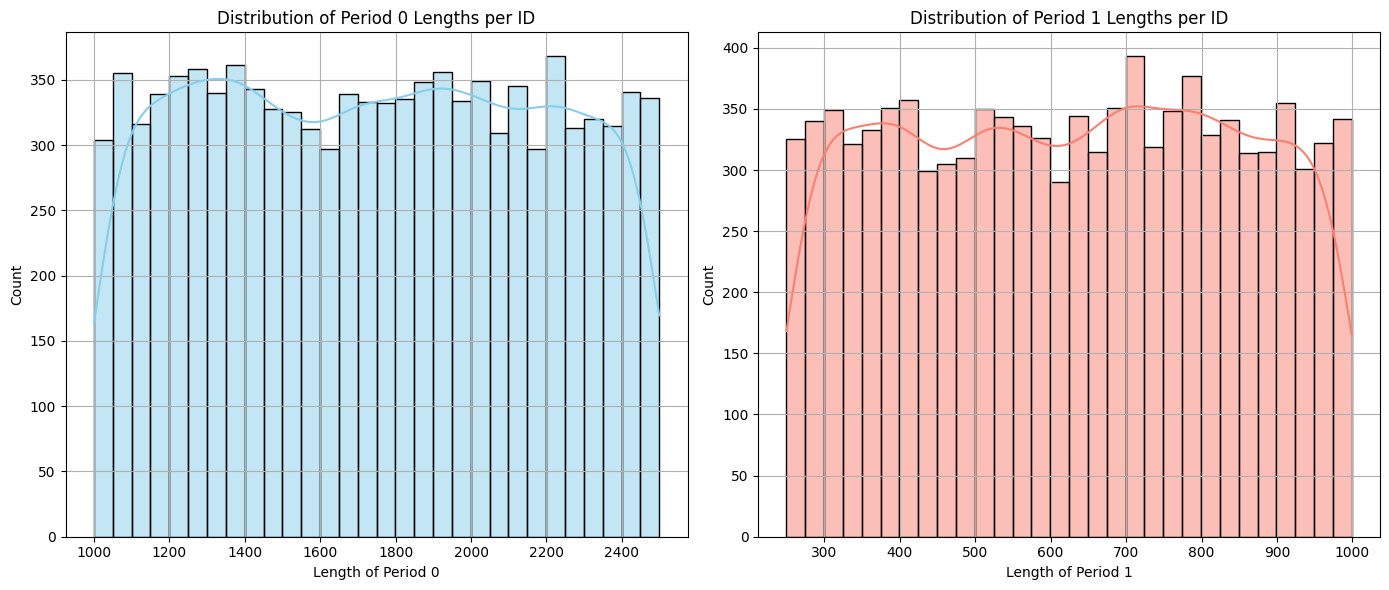

In [5]:
# 统计每个 id 在 period==0 和 period==1 下的长度
period_lengths = X_train.groupby(['id', 'period']).size().unstack(fill_value=0)
period0_lengths = period_lengths[0]
period1_lengths = period_lengths[1]

print('Period 0 长度分布描述性统计:\n', period0_lengths.describe())
print('Period 1 长度分布描述性统计:\n', period1_lengths.describe())

# 绘制两个子图
plt.figure(figsize=(14, 6))

# period==0
plt.subplot(1, 2, 1)
sns.histplot(period0_lengths, bins=30, kde=True, color='skyblue')
plt.xlabel('Length of Period 0')
plt.ylabel('Count')
plt.title('Distribution of Period 0 Lengths per ID')
plt.grid(True)

# period==1
plt.subplot(1, 2, 2)
sns.histplot(period1_lengths, bins=30, kde=True, color='salmon')
plt.xlabel('Length of Period 1')
plt.ylabel('Count')
plt.title('Distribution of Period 1 Lengths per ID')
plt.grid(True)

plt.tight_layout()
plt.show()

Period1 占比描述性统计:
 count    10001.000000
mean         0.266091
std          0.085668
min          0.094389
25%          0.199557
50%          0.264226
75%          0.325597
max          0.493709
dtype: float64


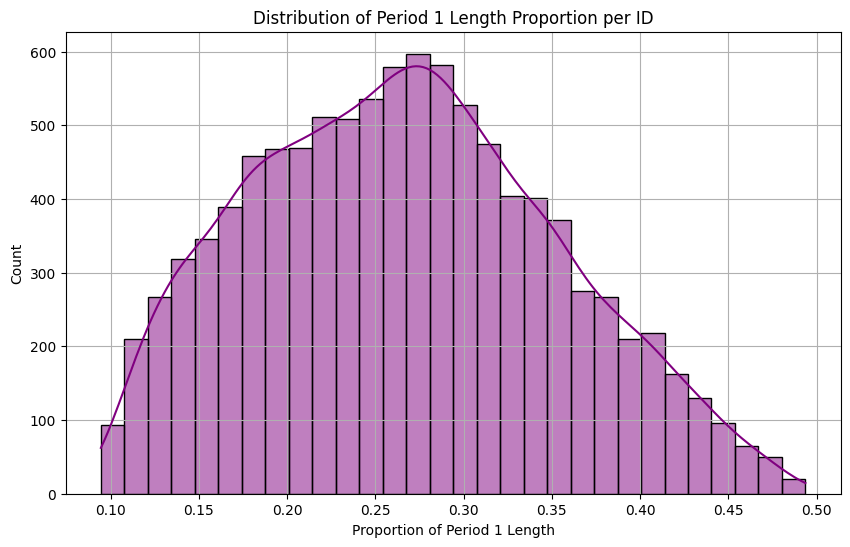

In [6]:
# 统计每个 id 在 period==0 和 period==1 下的长度
period_lengths = X_train.groupby(['id', 'period']).size().unstack(fill_value=0)
period0_lengths = period_lengths[0]
period1_lengths = period_lengths[1]
total_lengths = period0_lengths + period1_lengths

# 计算比例
period1_ratio = period1_lengths / total_lengths

print('Period1 占比描述性统计:\n', period1_ratio.describe())

# 绘制比例分布图
plt.figure(figsize=(10, 6))
sns.histplot(period1_ratio, bins=30, kde=True, color='purple')
plt.xlabel('Proportion of Period 1 Length')
plt.ylabel('Count')
plt.title('Distribution of Period 1 Length Proportion per ID')
plt.grid(True)
plt.show()

### Understanding `y_train`

This is a simple `pandas.Series` that tells if a dataset id has a structural breakpoint or not.

**Index:**
- `id`: the ID of the dataset

**Value:**
- `structural_breakpoint`: Boolean indicating whether a structural break occurred (`True`) or not (`False`)

In [12]:
y_train

id
0        False
1        False
2         True
3        False
4        False
         ...  
9996     False
9997     False
9998     False
9999     False
10000     True
Name: structural_breakpoint, Length: 10001, dtype: bool

### Plot by image

In [5]:
def TS2RP(data, args):
    dimension = args.get('dimension', 1)
    percentage = args.get('percentage', 1)
    rp = RecurrencePlot(dimension=dimension, percentage=percentage)
    data_reshaped = data.reshape(1, -1)
    rp_image = rp.fit_transform(data_reshaped)
    return rp_image

def TS2MTF(data, args):
    n_bins = args.get('n_bins', 10)
    image_size = args.get('image_size', 1.0)
    mtf = MarkovTransitionField(image_size=image_size, n_bins=n_bins)
    data_reshaped = data.reshape(1, -1)
    mtf_image = mtf.fit_transform(data_reshaped)
    return mtf_image

def TS2GAF(data, args):
    method = args.get('method', 'summation')
    gaf = GramianAngularField(method=method)
    data_reshaped = data.reshape(1, -1)
    gaf_image = gaf.fit_transform(data_reshaped)
    return gaf_image

In [ ]:
def plot_structure_break(img, df, break_flag, ax=None, title='Time Series Image'):
    # img shape: (1, H, W) 或 (H, W)
    if img.ndim == 3:
        image = img[0]
    else:
        image = img

    # 如果没有传入 ax，就新建一个图表
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    else:
        fig = ax.figure  # 获取子图所属的整个图对象

    cax = ax.imshow(image, cmap='viridis', aspect='auto')
    fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.04)

    # 找到 period 发生变化的边界索引
    period = df['period'].values
    boundary_indices = np.where(np.diff(period) != 0)[0] + 1

    # 绘制虚线
    for idx in boundary_indices:
        color = 'red' if break_flag else 'gray'
        label = 'Structure Break' if (break_flag and idx == boundary_indices[0]) else \
                'No Structure Break' if (not break_flag and idx == boundary_indices[0]) else None
        ax.axvline(x=idx, color=color, linestyle='--', linewidth=2, label=label)
        ax.axhline(y=idx, color=color, linestyle='--', linewidth=2)

    if boundary_indices.size > 0:
        ax.legend(loc='upper right')

    ax.set_title(title)
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Time Steps')

    return fig, ax

In [25]:
def plot_time_series_with_breaks(df_idx):
    target_length = 3000
    df = X_train.loc[df_idx]
    flag = y_train.loc[df_idx]
    # print(df)
    data = df['value'].values
    print(f"📈 Raw Timeseries loaded, shape: {data.shape}")

    if len(data) < target_length:
        print(f"⏳ Padding with {target_length - len(data)} zeros to reach target length {target_length}")
        data = np.pad(data, (0, target_length - len(data)), mode='constant')

    rp_img = TS2RP(data, {'dimension': 1, 'percentage': 0.1})
    print(f"📊 Recurrence Plot image shape: {rp_img.shape}")
    mtf_img = TS2MTF(data, {'n_bins': 8})
    print(f"📊 Markov Transition Field image shape: {mtf_img.shape}")
    gaf_img = TS2GAF(data, {'method': 'summation'})
    print(f"📊 Gramian Angular Field image shape: {gaf_img.shape}")

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    plot_structure_break(rp_img, df, break_flag=flag, ax=axs[0], title='Recurrence Plot')
    plot_structure_break(mtf_img, df, break_flag=flag, ax=axs[1], title='Markov Transition Field')
    plot_structure_break(gaf_img, df, break_flag=flag, ax=axs[2], title='Gramian Angular Field')

    plt.tight_layout()
    plt.show()

📈 Raw Timeseries loaded, shape: (1645,)
⏳ Padding with 1355 zeros to reach target length 3000
📊 Recurrence Plot image shape: (1, 3000, 3000)
📊 Markov Transition Field image shape: (1, 3000, 3000)


d:\anaconda3\envs\adia\Lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "


📊 Gramian Angular Field image shape: (1, 3000, 3000)


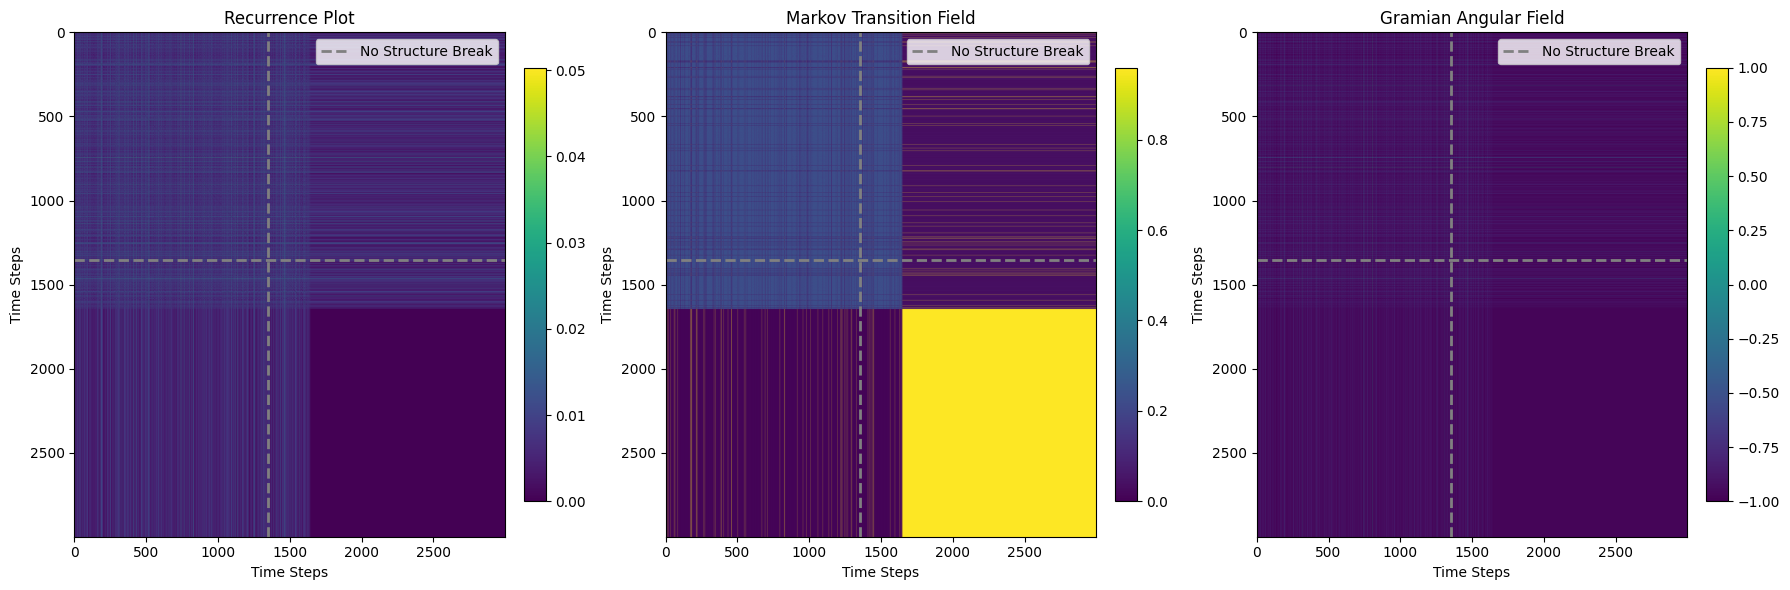

In [26]:
plot_time_series_with_breaks(0)

📈 Raw Timeseries loaded, shape: (2848,)
⏳ Padding with 152 zeros to reach target length 3000
📊 Recurrence Plot image shape: (1, 3000, 3000)
📊 Markov Transition Field image shape: (1, 3000, 3000)
📊 Gramian Angular Field image shape: (1, 3000, 3000)


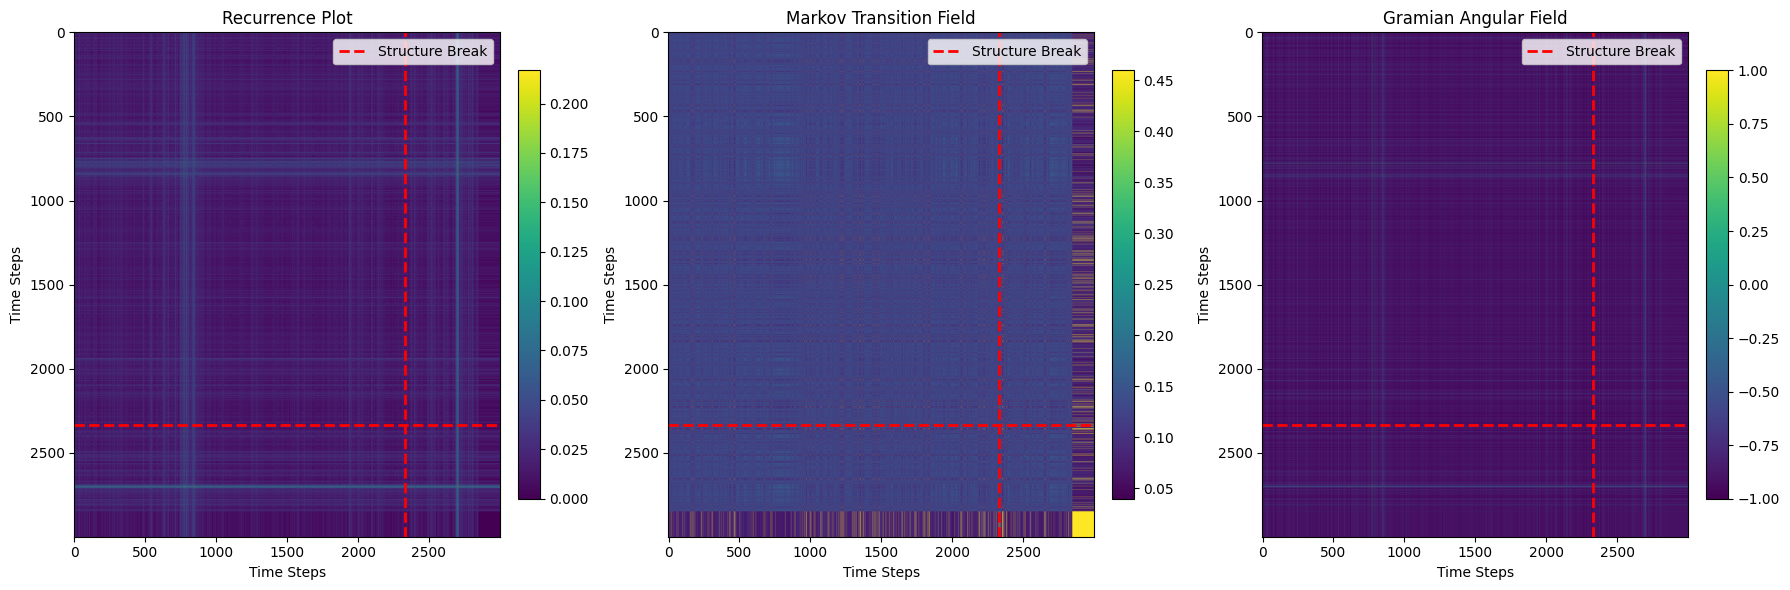

In [27]:
plot_time_series_with_breaks(2)

📈 Raw Timeseries loaded, shape: (2541,)
⏳ Padding with 459 zeros to reach target length 3000
📊 Recurrence Plot image shape: (1, 3000, 3000)
📊 Markov Transition Field image shape: (1, 3000, 3000)
📊 Gramian Angular Field image shape: (1, 3000, 3000)


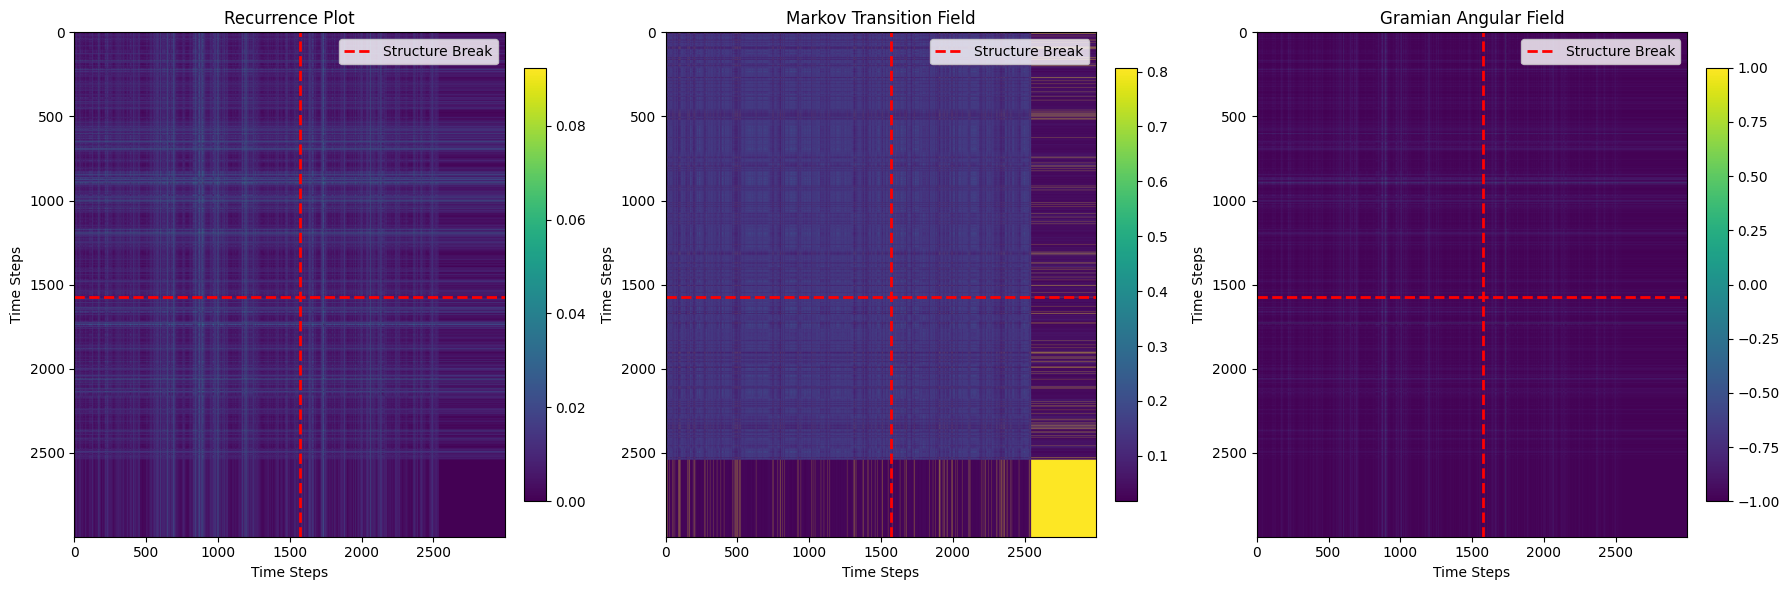

In [28]:
plot_time_series_with_breaks(6)

### Understanding `X_test`

The test data is provided as a **`list` of `pandas.DataFrame`s** with the same format as [`X_train`](#understanding-X_test).

It is structured as a list to encourage processing records one by one, which will be mandatory in the `infer()` function.

In [13]:
X_test[0]

value  period
id    time                  
10001 0     0.010753       0
      1    -0.031915       0
      2    -0.010989       0
      3    -0.011111       0
      4     0.011236       0
...              ...     ...
      2774 -0.013937       1
      2775 -0.015649       1
      2776 -0.009744       1
      2777  0.025375       1
      2778 -0.001515       1

[2779 rows x 2 columns]

时间序列长度描述性统计
 count     101.000000
mean     2451.663366
std       458.737578
min      1509.000000
25%      2074.000000
50%      2445.000000
75%      2780.000000
max      3431.000000
dtype: float64
时间序列长度分布


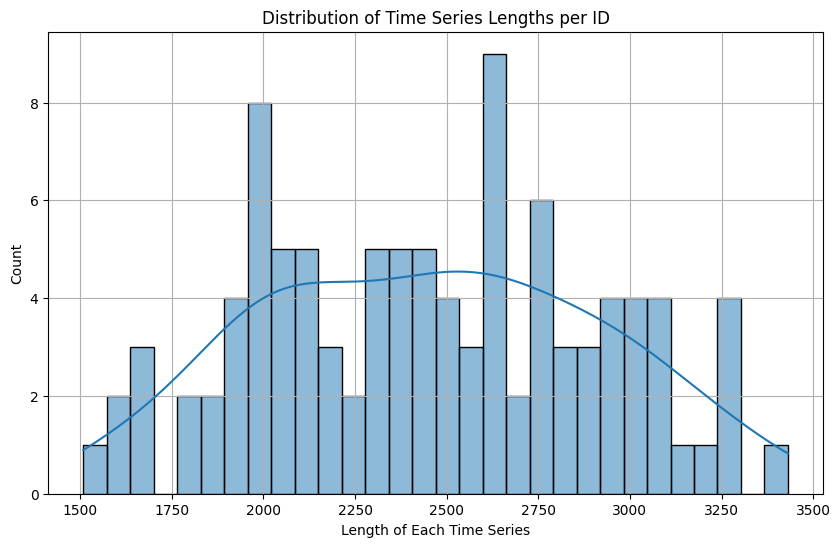

In [14]:
lengths = [len(df) for df in X_test]
lengths = pd.Series(lengths)
print('时间序列长度描述性统计\n', lengths.describe())
print('时间序列长度分布')
plt.figure(figsize=(10, 6))
sns.histplot(lengths, bins=30, kde=True)
plt.xlabel('Length of Each Time Series')
plt.ylabel('Count')
plt.title('Distribution of Time Series Lengths per ID')
plt.grid(True)
plt.show()

## Strategy Implementation

There are multiple approaches you can take to detect structural breaks:

1. **Statistical Tests**: Compare distributions before and after the boundary point;
2. **Feature Engineering**: Extract features from both segments for comparison;
3. **Time Series Modeling**: Detect deviations from expected patterns;
4. **Machine Learning**: Train models to recognize break patterns from labeled examples.

The baseline implementation below uses a simple statistical approach: a t-test to compare the distributions before and after the boundary point.

### The `train()` Function

In this function, you build and train your model for making inferences on the test data. Your model must be stored in the `model_directory_path`.

The baseline implementation below doesn't require a pre-trained model, as it uses a statistical test that will be computed at inference time.

In [ ]:
def train(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    model_directory_path: str,
):
    # For our baseline t-test approach, we don't need to train a model
    # This is essentially an unsupervised approach calculated at inference time
    model = None

    # You could enhance this by training an actual model, for example:
    # 1. Extract features from before/after segments of each time series
    # 2. Train a classifier using these features and y_train labels
    # 3. Save the trained model

    joblib.dump(model, os.path.join(model_directory_path, 'model.joblib'))

### The `infer()` Function

In the inference function, your trained model (if any) is loaded and used to make predictions on test data.

**Important workflow:**
1. Load your model;
2. Use the `yield` statement to signal readiness to the runner;
3. Process each dataset one by one within the for loop;
4. For each dataset, use `yield prediction` to return your prediction.

**Note:** The datasets can only be iterated once!

In [ ]:
def infer(
    X_test: typing.Iterable[pd.DataFrame],
    model_directory_path: str,
):
    model = joblib.load(os.path.join(model_directory_path, 'model.joblib'))

    yield  # Mark as ready

    # X_test can only be iterated once.
    # Before getting the next dataset, you must predict the current one.
    for dataset in X_test:
        # Baseline approach: Compute t-test between values before and after boundary point
        # The negative p-value is used as our score - smaller p-values (larger negative numbers)
        # indicate more evidence against the null hypothesis that distributions are the same,
        # suggesting a structural break
        def t_test(u: pd.DataFrame):
            return -scipy.stats.ttest_ind(
                u["value"][u["period"] == 0],  # Values before boundary point
                u["value"][u["period"] == 1],  # Values after boundary point
            ).pvalue

        prediction = t_test(dataset)
        yield prediction  # Send the prediction for the current dataset

        # Note: This baseline approach uses a t-test to compare the distributions
        # before and after the boundary point. A smaller p-value (larger negative number)
        # suggests stronger evidence that the distributions are different,
        # indicating a potential structural break.

## Local testing

To make sure your `train()` and `infer()` function are working properly, you can call the `crunch.test()` function that will reproduce the cloud environment locally. <br />
Even if it is not perfect, it should give you a quick idea if your model is working properly.

In [ ]:
crunch.test(
    # Uncomment to disable the train
    # force_first_train=False,

    # Uncomment to disable the determinism check
    # no_determinism_check=True,
)

## Results

Once the local tester is done, you can preview the result stored in `data/prediction.parquet`.

In [ ]:
prediction = pd.read_parquet("data/prediction.parquet")
prediction

### Local scoring

You can call the function that the system uses to estimate your score locally.

In [ ]:
# Load the targets
target = pd.read_parquet("data/y_test.reduced.parquet")["structural_breakpoint"]

# Call the scoring function
sklearn.metrics.roc_auc_score(
    target,
    prediction,
)